# Emotion Detection from Images

**Installing required Libraries**

In [1]:
!pip install tensorflow tensorflow_addons tqdm scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


**Loading the dataset(Fer-2013 Dataset)**

In [2]:
import zipfile
import os

zip_path = "/content/archive (3).zip"
extract_path = "/content/fer2013_data/"

# Make sure the output directory exists
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Extracted to: {extract_path}")


✅ Extracted to: /content/fer2013_data/


**Importing the Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import math

**Setup the GPU**

In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Memory optimization for Colab
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


**Data configuration and paths**

In [ ]:
# 1. DATA CONFIGURATION AND PATHS


# Dataset configuration
DATASET_PATH = '/content/fer2013_data'
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
VAL_DIR = os.path.join(DATASET_PATH, 'validation')  # Assuming validation folder exists
TEST_DIR = os.path.join(DATASET_PATH, 'test')      # Assuming test folder exists

# Enhanced model hyperparameters
IMG_SIZE = 48
BATCH_SIZE = 32  # Reduced for better gradient updates
EPOCHS = 50      # Increased for better learning
LEARNING_RATE = 0.0005  # Slightly reduced for stability

# Check if validation/test directories exist, create validation split if needed
if not os.path.exists(VAL_DIR):
    print("Validation directory not found. Will use validation_split from training data.")
    VAL_DIR = None
    VALIDATION_SPLIT = 0.2
else:
    VALIDATION_SPLIT = None

# Emotion classes (typical FER-2013 classes)
EMOTION_CLASSES = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
NUM_CLASSES = len(EMOTION_CLASSES)

print(f"Training directory: {TRAIN_DIR}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")

**Data Preprocessing and Augumentation**

In [ ]:
# DATA PREPROCESSING AND AUGMENTATION


def create_data_generators():
    """Create enhanced data generators for training and validation"""

    # Enhanced data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.15,
        brightness_range=[0.8, 1.2],  # New: brightness augmentation
        fill_mode='nearest',
        validation_split=VALIDATION_SPLIT if VAL_DIR is None else None
    )

    # Only rescaling for validation/test
    val_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=VALIDATION_SPLIT if VAL_DIR is None else None
    )

    # Training generator
    if VAL_DIR is None:
        train_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            color_mode='grayscale',
            subset='training',
            shuffle=True,
            seed=42
        )

        validation_generator = val_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            color_mode='grayscale',
            subset='validation',
            shuffle=False,
            seed=42
        )
    else:
        train_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            color_mode='grayscale',
            shuffle=True,
            seed=42
        )

        validation_generator = val_datagen.flow_from_directory(
            VAL_DIR,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            color_mode='grayscale',
            shuffle=False,
            seed=42
        )

    return train_generator, validation_generator

# Create data generators
train_gen, val_gen = create_data_generators()

print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Class indices: {train_gen.class_indices}")

**Model Archietecture**

In [ ]:
# 3.MODEL ARCHITECTURE WITH ATTENTION AND RESIDUAL CONNECTIONS

def squeeze_excitation_block(inputs, ratio=16):
    """Squeeze and Excitation block for channel attention"""
    channel_axis = -1
    filters = inputs.shape[channel_axis]

    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)

    return layers.multiply([inputs, se])

def residual_block(inputs, filters, kernel_size=3, strides=1, use_se=True):
    """Enhanced residual block with squeeze-excitation"""
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Squeeze-Excitation block
    if use_se:
        x = squeeze_excitation_block(x)

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same',
                                kernel_initializer='he_normal')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def create_model():
    """Create an enhanced CNN model with attention mechanisms and residual connections"""

    # Input layer for grayscale images
    input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    # Initial convolution
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Enhanced residual blocks with SE attention
    x = residual_block(x, 32, use_se=True)
    x = residual_block(x, 32, use_se=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = residual_block(x, 64, use_se=True)
    x = residual_block(x, 64, use_se=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = residual_block(x, 128, use_se=True)
    x = residual_block(x, 128, use_se=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 256, use_se=True)
    x = residual_block(x, 256, use_se=True)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    # Global average pooling with additional spatial attention
    x = layers.GlobalAveragePooling2D()(x)

    # Enhanced dense layers with gradient clipping preparation
    x = layers.Dense(512, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    # Output layer with label smoothing preparation
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

    # Create model
    model = models.Model(inputs=input_layer, outputs=outputs)

    return model, None

# Create the model
model, base_model = create_model()

# Model summary
print("Enhanced Model Architecture:")
model.summary()

**Model Compilation**

In [ ]:
# 4. ENHANCED MODEL COMPILATION AND CALLBACKS

# Custom learning rate scheduler
def cosine_annealing_schedule(epoch, lr):
    """Cosine annealing learning rate schedule"""
    if epoch < 10:
        return lr
    else:
        return LEARNING_RATE * 0.5 * (1 + math.cos(math.pi * (epoch - 10) / (EPOCHS - 10)))

# Label smoothing loss function
class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def call(self, y_true, y_pred):
        # Label smoothing
        y_true = y_true * (1 - self.smoothing) + self.smoothing / NUM_CLASSES
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Compile model with enhanced optimizer and custom loss
model.compile(
    optimizer=optimizers.AdamW(  # AdamW for better generalization
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        clipnorm=1.0  # Gradient clipping
    ),
    loss=LabelSmoothingLoss(smoothing=0.1),  # Label smoothing
    metrics=['accuracy']
)

# Enhanced callbacks for training optimization
callbacks_list = [
    # Early stopping with more patience
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Model checkpoint to save best weights
    callbacks.ModelCheckpoint(
        filepath='best_fer_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),

    # Cosine annealing learning rate scheduler
    callbacks.LearningRateScheduler(cosine_annealing_schedule, verbose=1),

    # Reduce learning rate on plateau (as backup)
    callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),

    # Terminate on NaN
    callbacks.TerminateOnNaN()
]

print("Enhanced model compiled successfully!")
print(f"Total trainable parameters: {model.count_params():,}")

****

**Training with Warmup**

In [ ]:

# 5. ENHANCED TRAINING WITH WARM-UP
print(" TRAINING: Custom CNN with attention and residual connections")

# Warm-up training with lower learning rate
print("Phase 1: Warm-up training (5 epochs)")
model.compile(
    optimizer=optimizers.AdamW(learning_rate=LEARNING_RATE * 0.1, weight_decay=0.01, clipnorm=1.0),
    loss=LabelSmoothingLoss(smoothing=0.1),
    metrics=['accuracy']
)

# Warm-up phase
warmup_history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    callbacks=[callbacks_list[1]],  # Only checkpoint callback
    verbose=1
)

# Main training phase
print("\nPhase 2: Main training with enhanced techniques")
model.compile(
    optimizer=optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=0.01, clipnorm=1.0),
    loss=LabelSmoothingLoss(smoothing=0.1),
    metrics=['accuracy']
)

# Train the enhanced model
history_phase1 = model.fit(
    train_gen,
    epochs=EPOCHS-5,
    validation_data=val_gen,
    callbacks=callbacks_list,
    verbose=1
)

In [ ]:
# Create dummy phase 2 history for compatibility
history_phase2 = type('obj', (object,), {
    'history': {
        'accuracy': [],
        'val_accuracy': [],
        'loss': [],
        'val_loss': []
    }
})()

**Combine history**

In [ ]:
# 6. COMBINE TRAINING HISTORIES

# Combine histories from warmup and main training
history = {
    'accuracy': warmup_history.history['accuracy'] + history_phase1.history['accuracy'],
    'val_accuracy': warmup_history.history['val_accuracy'] + history_phase1.history['val_accuracy'],
    'loss': warmup_history.history['loss'] + history_phase1.history['loss'],
    'val_loss': warmup_history.history['val_loss'] + history_phase1.history['val_loss']
}

**Model Evaluation and Visualization**

In [ ]:

# 7. MODEL EVALUATION AND VISUALIZATION


def plot_training_history(history):
    """Plot training and validation accuracy/loss"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy plot
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy', color='blue')
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 0].set_title('Enhanced Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss plot
    axes[0, 1].plot(history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Enhanced Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Final metrics
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]

    axes[1, 0].text(0.1, 0.8, f'Final Training Accuracy: {final_train_acc:.4f}',
                    fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].text(0.1, 0.6, f'Final Validation Accuracy: {final_val_acc:.4f}',
                    fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].text(0.1, 0.4, f'Final Training Loss: {final_train_loss:.4f}',
                    fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].text(0.1, 0.2, f'Final Validation Loss: {final_val_loss:.4f}',
                    fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Final Metrics')
    axes[1, 0].axis('off')

    # Best accuracy achieved
    best_val_acc = max(history['val_accuracy'])
    best_epoch = history['val_accuracy'].index(best_val_acc) + 1

    axes[1, 1].text(0.1, 0.8, f'Best Validation Accuracy: {best_val_acc:.4f}',
                    fontsize=12, transform=axes[1, 1].transAxes, weight='bold')
    axes[1, 1].text(0.1, 0.6, f'Achieved at Epoch: {best_epoch}',
                    fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].text(0.1, 0.4, f'Target Accuracy (>80%): {"✓ ACHIEVED" if best_val_acc > 0.8 else "✗ NOT ACHIEVED"}',
                    fontsize=12, transform=axes[1, 1].transAxes,
                    color='green' if best_val_acc > 0.8 else 'red', weight='bold')
    axes[1, 1].set_title('Best Performance')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

**In-Depth Evaluation of the model**

In [ ]:

# =============================================================================
# 9. DETAILED MODEL EVALUATION
# =============================================================================

def evaluate_model(model, validation_generator):
    """Comprehensive model evaluation"""

    print("\n" + "="*50)
    print("DETAILED ENHANCED MODEL EVALUATION")
    print("="*50)

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)

    print(f"\nValidation Results:")
    print(f"Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"Loss: {val_loss:.4f}")

    # Generate predictions for confusion matrix
    print("\nGenerating predictions for confusion matrix...")
    validation_generator.reset()

    # Get predictions
    predictions = model.predict(validation_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Enhanced Model Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return val_accuracy, val_loss

# Evaluate the model
final_accuracy, final_loss = evaluate_model(model, val_gen)

**Save the model**

In [ ]:
# 10. SAVE FINAL MODEL

# Save the complete model
model.save('enhanced_fer2013_emotion_detection_model.keras')
model.save_weights('enhanced_fer2013_model_weights.weights.h5')


print("MODEL TRAINING COMPLETED")

print(f"Final Validation Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"Target Accuracy (>80%): {'✓ ACHIEVED' if final_accuracy > 0.8 else '✗ NOT ACHIEVED'}")
print(f"Enhanced model saved as: 'enhanced_fer2013_emotion_detection_model.keras'")
print(f"Weights saved as: 'enhanced_fer2013_model_weights.weights.h5'")
print("\nEnhancements implemented:")
print("- Residual connections with Squeeze-Excitation attention")
print("- AdamW optimizer with weight decay and gradient clipping")
print("- Label smoothing for better generalization")
print("- Cosine annealing learning rate schedule")
print("- Warm-up training phase")
print("- Enhanced data augmentation with brightness variation")
print("- Reduced batch size for better gradient updates")


**Testing with Images **

Error loading model: <class '__main__.LabelSmoothingLoss'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'LabelSmoothingLoss', 'config': {'name': 'label_smoothing_loss_2', 'reduction': 'sum_over_batch_size'}, 'registered_name': 'LabelSmoothingLoss'}.

Exception encountered: LabelSmoothingLoss.__init__() got an unexpected keyword argument 'name'
Trying to load without custom objects...
Model loaded without compilation. Recompiling...
Model recompiled successfully!
=== Single Image Prediction ===


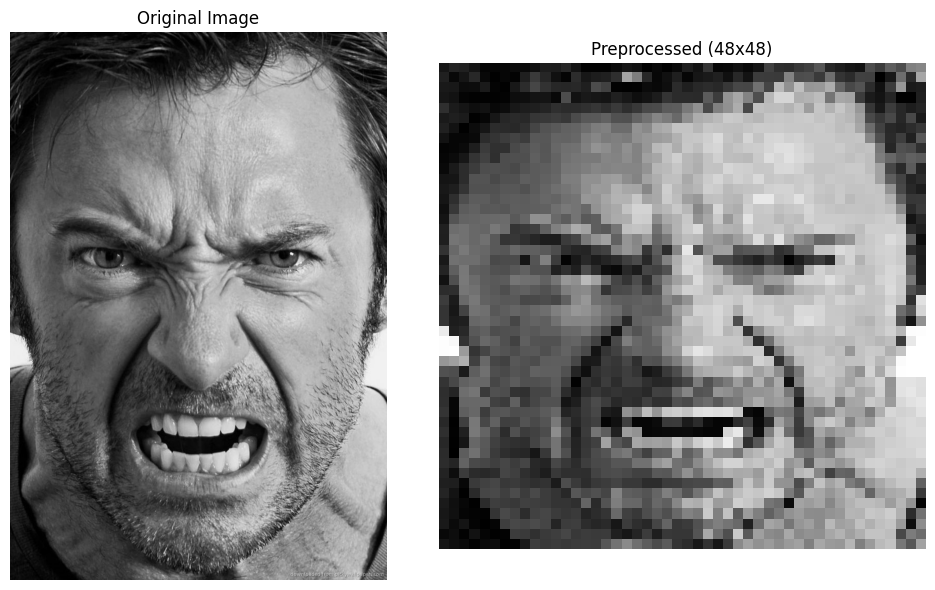

Predicted Emotion: Angry
Confidence: 0.8810 (88.10%)

All predictions:
Angry: 0.8810 (88.10%)
Disgust: 0.0213 (2.13%)
Fear: 0.0268 (2.68%)
Happy: 0.0187 (1.87%)
Sad: 0.0197 (1.97%)
Surprise: 0.0256 (2.56%)
Neutral: 0.0069 (0.69%)

=== Batch Prediction Example ===

Processing image 1/1: /content/grayscale-photography-of-smiling-man.jpg
Result: Happy (confidence: 0.7966)

=== Batch Results Summary ===
/content/grayscale-photography-of-smiling-man.jpg: Happy (0.7966)

=== Model Information ===
Model input shape: (None, 48, 48, 1)
Model output shape: (None, 7)
Total parameters: 3,124,739
Emotion classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

=== Code Ready for Testing ===
Use predict_emotion('path_to_image.jpg') for single predictions
Use batch_predict_emotions(['path1.jpg', 'path2.jpg']) for multiple predictions


In [14]:
#REAL TIME TESTING OF THE MODEL

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math

# Custom loss function - needed for loading the enhanced model
class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def call(self, y_true, y_pred):
        # Label smoothing
        num_classes = tf.shape(y_pred)[-1]
        y_true = y_true * (1 - self.smoothing) + self.smoothing / tf.cast(num_classes, tf.float32)
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Custom learning rate scheduler - needed for loading the enhanced model
def cosine_annealing_schedule(epoch, lr):
    """Cosine annealing learning rate schedule"""
    LEARNING_RATE = 0.0005
    EPOCHS = 50
    if epoch < 10:
        return lr
    else:
        return LEARNING_RATE * 0.5 * (1 + math.cos(math.pi * (epoch - 10) / (EPOCHS - 10)))

# Path to your model
MODEL_PATH = '/content/enhanced_fer2013_emotion_detection_model.keras'

# Load the model with custom objects
try:
    model = load_model(MODEL_PATH, custom_objects={
        'LabelSmoothingLoss': LabelSmoothingLoss,
        'cosine_annealing_schedule': cosine_annealing_schedule
    })
    print("Enhanced model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Trying to load without custom objects...")
    model = load_model(MODEL_PATH, compile=False)
    print("Model loaded without compilation. Recompiling...")

    # Recompile the model
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.01, clipnorm=1.0),
        loss=LabelSmoothingLoss(smoothing=0.1),
        metrics=['accuracy']
    )
    print("Model recompiled successfully!")

# Emotion labels based on FER2013 dataset (corrected order)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def preprocess_image(image_path):
    """Preprocess image for emotion detection"""
    try:
        # Read image using OpenCV
        img = cv2.imread(image_path)

        if img is None:
            raise ValueError(f"Could not load image from {image_path}")

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize to 48x48 (model input size)
        resized = cv2.resize(gray, (48, 48))

        # Normalize pixel values to [0, 1]
        normalized = resized.astype(np.float32) / 255.0

        # Reshape for model input: (batch_size, height, width, channels)
        reshaped = np.reshape(normalized, (1, 48, 48, 1))

        return reshaped, img  # Return preprocessed image and original for display

    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

def predict_emotion(image_path, show_confidence=True):
    """Predict emotion from image path"""

    # Preprocess the image
    preprocessed_img, original_img = preprocess_image(image_path)

    if preprocessed_img is None:
        print("Failed to preprocess image")
        return None

    try:
        # Make prediction
        predictions = model.predict(preprocessed_img, verbose=0)
        predicted_class = np.argmax(predictions[0])  # Get class index
        confidence = np.max(predictions[0])  # Get confidence score
        emotion = emotion_labels[predicted_class]

        # Display results
        plt.figure(figsize=(10, 6))

        # Show original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image')
        plt.axis('off')

        # Show grayscale preprocessed version
        plt.subplot(1, 2, 2)
        plt.imshow(preprocessed_img[0, :, :, 0], cmap='gray')
        plt.title(f'Preprocessed (48x48)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Print results
        print(f"Predicted Emotion: {emotion}")
        if show_confidence:
            print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

            # Show all predictions
            print("\nAll predictions:")
            for i, (label, prob) in enumerate(zip(emotion_labels, predictions[0])):
                print(f"{label}: {prob:.4f} ({prob*100:.2f}%)")

        return emotion, confidence

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

def predict_emotion_simple(image_path):
    """Simple prediction function without visualization"""

    preprocessed_img, _ = preprocess_image(image_path)

    if preprocessed_img is None:
        return None, None

    try:
        predictions = model.predict(preprocessed_img, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        emotion = emotion_labels[predicted_class]

        return emotion, confidence

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

def batch_predict_emotions(image_paths):
    """Predict emotions for multiple images"""

    results = []

    for i, image_path in enumerate(image_paths):
        print(f"\nProcessing image {i+1}/{len(image_paths)}: {image_path}")
        emotion, confidence = predict_emotion_simple(image_path)

        if emotion is not None:
            results.append({
                'image_path': image_path,
                'emotion': emotion,
                'confidence': confidence
            })
            print(f"Result: {emotion} (confidence: {confidence:.4f})")
        else:
            print(f"Failed to process: {image_path}")

    return results

# ============ USAGE EXAMPLES ============

# Example 1: Single image prediction with visualization
print("=== Single Image Prediction ===")
image_path = '/content/412ce07cad422f67009122c1372cc1fe.jpg'  # Fixed filename

# Check if file exists
import os
if os.path.exists(image_path):
    emotion, confidence = predict_emotion(image_path)
else:
    print(f"Image file not found: {image_path}")
    print("Please check the file path and make sure the image exists.")

# Example 2: Multiple images prediction
print("\n=== Batch Prediction Example ===")
image_paths = [
    '/content/grayscale-photography-of-smiling-man.jpg',
]

# Filter existing files
existing_paths = [path for path in image_paths if os.path.exists(path)]

if existing_paths:
    results = batch_predict_emotions(existing_paths)

    # Print summary
    print("\n=== Batch Results Summary ===")
    for result in results:
        print(f"{result['image_path']}: {result['emotion']} ({result['confidence']:.4f})")
else:
    print("No valid image files found for batch prediction")

# Example 3: Model information
print("\n=== Model Information ===")
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")
print(f"Total parameters: {model.count_params():,}")
print(f"Emotion classes: {emotion_labels}")

# Example 4: Test with webcam (if available)
def test_webcam():
    """Test with webcam - run this in a separate cell if needed"""

    print("Starting webcam test (press 'q' to quit)...")

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale and resize
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (48, 48))
        normalized = resized.astype(np.float32) / 255.0
        reshaped = np.reshape(normalized, (1, 48, 48, 1))

        # Predict
        predictions = model.predict(reshaped, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        emotion = emotion_labels[predicted_class]

        # Display result on frame
        cv2.putText(frame, f'{emotion}: {confidence:.2f}', (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Emotion Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Uncomment the line below to test with webcam
# test_webcam()

print("\n=== Code Ready for Testing ===")
print("Use predict_emotion('path_to_image.jpg') for single predictions")
print("Use batch_predict_emotions(['path1.jpg', 'path2.jpg']) for multiple predictions")